<a href="https://colab.research.google.com/github/aso85b/AI-Agent/blob/main/Privacy_Preserving_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trained weights: [-1.00382768e-03  2.23610282e-04  6.27926451e-02 -1.49058844e-03
  2.37494101e-04 -3.64371073e-01  1.19882350e-03 -4.01002327e-02
 -7.43369039e-04 -7.66289824e-04  3.13414270e-02 -5.87126822e-04
  2.04576410e-01  9.68326659e-04  1.27133124e-02  6.32616217e-02
 -5.52318082e-02 -5.74699233e-05  6.41162247e-02 -7.79420814e-04]
Test Log Loss: 0.5060912784726749


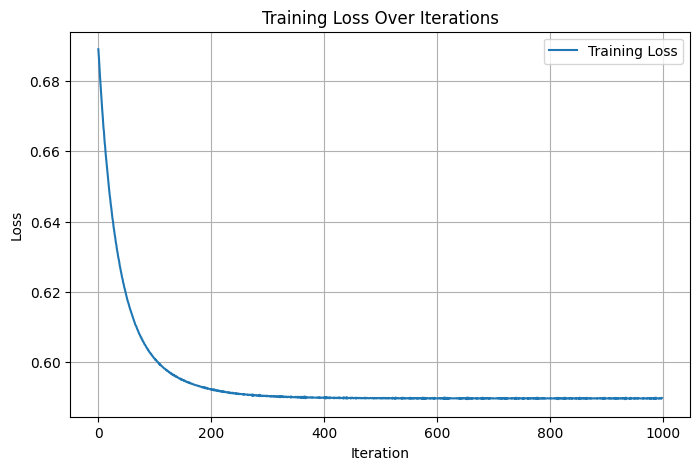

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy.optimize import minimize

# Generate synthetic data
def generate_data(n_samples=1000, n_features=20, random_state=42):
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features, n_informative=10, random_state=random_state
    )
    y = 2 * y - 1  # Convert to {-1, +1} for classification
    return X, y

# Elastic Net Regularization
def elastic_net_regularizer(f, lambda_1, lambda_2):
    return lambda_1 * np.sum(np.abs(f)) + lambda_2 * np.sum(f**2)

# Objective function for logistic loss + regularization + privacy noise
def objective_perturbation(f, X, y, lambda_1, lambda_2, noise):
    n = X.shape[0]
    logits = np.dot(X, f)
    loss = np.mean(np.log(1 + np.exp(-y * logits)))
    regularization = elastic_net_regularizer(f, lambda_1, lambda_2)
    noise_term = np.dot(noise, f) / n
    return loss + regularization + noise_term

# Gradient descent with privacy-preserving objective perturbation
def privacy_preserving_sgd(X, y, epsilon, lambda_1, lambda_2, n_iterations=1000, learning_rate=0.01):
    d = X.shape[1]
    f = np.zeros(d)  # Initialize weights

    # Generate Gaussian noise
    noise_scale = 1 / (epsilon * np.sqrt(X.shape[0]))
    noise = np.random.normal(0, noise_scale, size=d)

    loss_history = []

    for _ in range(n_iterations):
        # Compute gradient
        logits = np.dot(X, f)
        gradient = -np.dot(X.T, y / (1 + np.exp(y * logits))) / X.shape[0]

        # Add gradient of regularization and noise
        gradient += lambda_1 * np.sign(f) + 2 * lambda_2 * f + noise / X.shape[0]

        # Update weights
        f -= learning_rate * gradient

        # Compute loss for tracking
        loss = objective_perturbation(f, X, y, lambda_1, lambda_2, noise)
        loss_history.append(loss)

    return f, loss_history

# Main execution
if __name__ == "__main__":
    # Parameters
    epsilon = 1.0  # Privacy budget
    lambda_1 = 0.1  # L1 regularization strength
    lambda_2 = 0.1  # L2 regularization strength
    n_iterations = 1000
    learning_rate = 0.01

    # Generate data
    X, y = generate_data(n_samples=1000, n_features=20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train privacy-preserving classifier
    f, loss_history = privacy_preserving_sgd(X_train, y_train, epsilon, lambda_1, lambda_2, n_iterations, learning_rate)

    # Evaluate on test data
    logits = np.dot(X_test, f)
    predictions = 1 / (1 + np.exp(-logits))
    loss = log_loss(y_test, predictions)

    print("Trained weights:", f)
    print("Test Log Loss:", loss)

    # Plot loss history
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(loss_history)), loss_history, label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()
